# **Prediction with sequential data**

### **1) Long Short Time Memory Model**

# 0. Important necessary modules

In [1]:
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1.Data Preparation

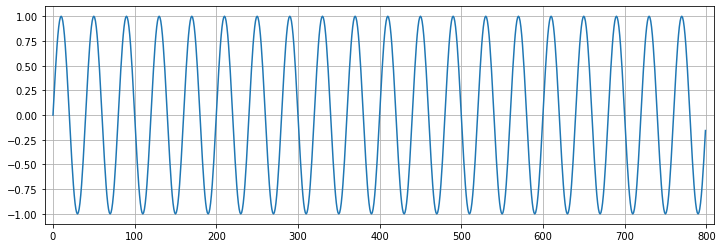

In [2]:
x = torch.linspace(0,799, 800)
y = torch.sin(x * 2 * np.pi / 40)

plt.figure(figsize = (12,4))
plt.xlim(-10, 810)
plt.grid(True)
plt.plot(y.numpy() )

In [3]:
test_size = 40
train_set = y[:-test_size]
test_set = y[-test_size:]
print(len(train_set), len(test_set))

760 40


### Inspecting dataset

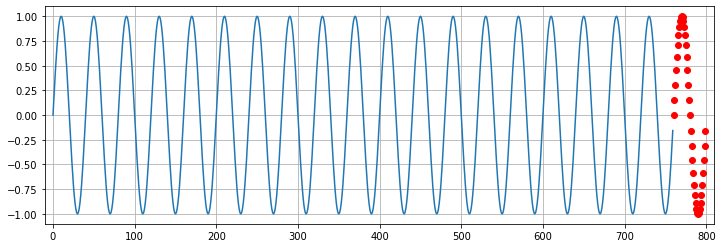

In [4]:
plt.figure(figsize = (12,4))
plt.xlim(-10, 810)
plt.grid(True)
plt.plot(x[:-test_size].numpy(), y[:-test_size].numpy())
plt.plot(x[-test_size:].numpy(), y[-test_size:].numpy(), 'ro')

# 2. Model Define

### **Data window**

In [5]:
def input_data(seq, ws):
  output = []
  L = len(seq)
  print("length of input training data = {}".format(L))
  for i in range(L - ws):
      window = seq[i:i+ws]
      label = seq[i+ws:i+ws+1]
      output.append((window, label))   
  return output

In [6]:
window_size = 40
train_data = input_data(train_set, window_size)

length of input training data = 760


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


tensor([1.7485e-07])


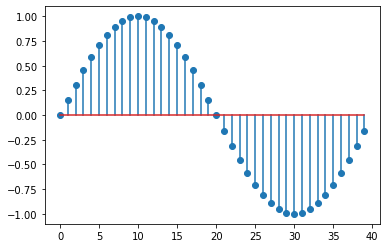

In [7]:
plt.stem(train_data[0][0])
print(train_data[0][1])

### **LSTM Model**

In [8]:
class LongShortTM(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 50, out_size = 1):
        super(LongShortTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, out_size)
        self.hidden = (torch.zeros(1,1,hidden_size), torch.zeros(1,1,hidden_size))

    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq), 1, -1), self.hidden)
        pred = self.linear(lstm_out.view( len(seq), -1))
        return pred[-1]


# 3. Simulation Define

In [9]:
model = LongShortTM()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
print(model)

LongShortTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)


In [10]:
epochs = 20
future = 40
for i in range(epochs):
  for seq, y_train in train_data:
    optimizer.zero_grad()
    model.hidden = (torch.zeros(1,1,model.hidden_size) ,
                    torch.zeros(1,1,model.hidden_size))
    
    y_pred = model(seq)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
 
  print(f"Epoch {i} Loss {loss.item()} ")
  
  preds = train_set[-window_size:].tolist()
  for f in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
      model.hidden = (torch.zeros(1,1,model.hidden_size) ,
                      torch.zeros(1,1,model.hidden_size))
      preds.append(model(seq).item())
 
  loss = criterion(torch.tensor(preds[-window_size :]), y[760:] )
  print(f'Performance on test range: {loss}')

Epoch 0 Loss 0.08312472701072693 
Performance on test range: 0.5881235599517822
Epoch 1 Loss 0.052853573113679886 
Performance on test range: 0.5400833487510681
Epoch 2 Loss 0.022946087643504143 
Performance on test range: 0.4475763738155365
Epoch 3 Loss 0.003082860726863146 
Performance on test range: 0.1785610020160675
Epoch 4 Loss 0.0002477149828337133 
Performance on test range: 0.022061631083488464
Epoch 5 Loss 0.00010925712558673695 
Performance on test range: 0.009549649432301521
Epoch 6 Loss 0.0001081109803635627 
Performance on test range: 0.007710558827966452
Epoch 7 Loss 0.00011545478628249839 
Performance on test range: 0.006735830567777157
Epoch 8 Loss 0.00012097787111997604 
Performance on test range: 0.005988932680338621
Epoch 9 Loss 0.00012409237388055772 
Performance on test range: 0.005381670780479908
Epoch 10 Loss 0.00012520435848273337 
Performance on test range: 0.0048805950209498405
Epoch 11 Loss 0.0001247662294190377 
Performance on test range: 0.0044630700722336

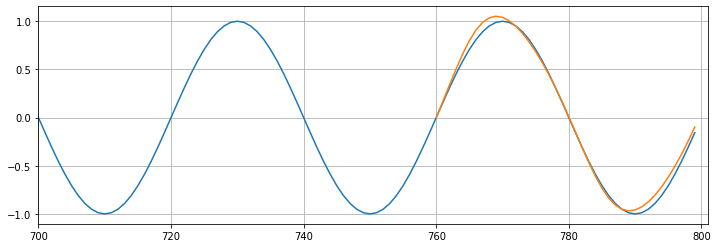

In [11]:
plt.figure(figsize=(12,4))
plt.xlim(700, 801)
plt.grid(True)
plt.plot(y.numpy())
plt.plot(range(760,800), preds[window_size:])
plt.show()